# 1. Introduction

# 2. Gaussian Process

This section gives some background on the theory behind Gaussian processes. Feel free to skip it if you are more interested in the application.

A Gaussian process is a Bayesian non-parametric method. Usually in a Bayesian framework we are interested in inferring a distribution over parameters of a second distribution that we use to fit the data (the likelihood). In this case, we are directly inferring a distribution over functions.

The basic idea when performing a Gaussian process regression is that our Gaussian process will assign a probability to the potentially infinite functions that could fit our data. This probability expresses the uncertainty of the model, which gives us a strong indication of how much should we trust the point prediction - i.e. the mean of the resulting probability distribution.

## 2.1 Multivariate Gaussian Distribution

The foundation of the Gaussian process is the multivariate Gaussian distribution, which is the multidimensional generalization of the Gaussian distribution. In the multivariate case, the distribution is defined by a mean vector $\mu$ and a symmetric and positive definite covariance matrix $\Sigma$. The first represents the expected value of each random variable, while the latter describes two phenomenons: its diagonal expresses the variance of each dimension and the off-diagonal the covariance between all the random variables. It basically measures how the random variables change together.

The multivariate Gaussian distribution has the following joint probability density:

$$p(x|\mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}}\exp\big(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\big)$$

where $x$ is a random vector of size $d$ and $|\Sigma|$ is the determinant of the $d$x$d$ matrix $\Sigma$.

To understand better how these parameters change the distribution let's plot two simple examples on a two-dimensional Gaussian distribution. In the first example the variables are independent and in the second they covary (see the off-diagonal values).

$$\begin{eqnarray*}
\mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
1 & 0\\
0 & 1
\end{array}\right]\right)
\qquad 
\mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
1 & 0.8\\
0.8 & 1
\end{array}\right]\right)
\end{eqnarray*}$$

This can be generalized to:


$$\begin{eqnarray*}
\left[\begin{array}{c}
X\\
Y
\end{array}\right] \sim 
\mathcal{N}\left(\left[\begin{array}{c}
\mu_x\\
\mu_y
\end{array}\right],\left[\begin{array}{ccc}
\Sigma_{xx} & \Sigma_{xy}\\
\Sigma_{yx} & \Sigma_{yy}
\end{array}
\right]\right)
\end{eqnarray*}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

pd.options.mode.chained_assignment = None

In [2]:
def multivariate_normal(x, d, mean, covariance):
    return (1. / (np.sqrt((2*np.pi)**d * np.linalg.det(covariance))) 
            * np.exp(-(np.linalg.solve(covariance, x-mean).T.dot(x-mean))/2))

In [3]:
def calculate_pdf(mean, covariance, d):
    x_ = 100
    xs = np.linspace(-5, 5, x_)
    ys = np.linspace(-5, 5, x_)
    x, y = np.meshgrid(xs, ys)
    pdf = np.zeros((x_, x_))
    for i in range(x_):
        for j in range(x_):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x[i,j]], [y[i,j]]]), 
                d, mean, covariance)
    return x, y, pdf

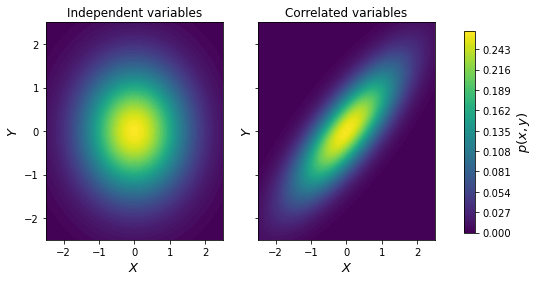

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True)
d = 2 

mean_ind = np.matrix([[0.], [0.]])
covariance_ind = np.matrix([
    [1., 0.], 
    [0., 1.]])
x, y, p = calculate_pdf(
    mean_ind, covariance_ind, d)

ax[0].contourf(x, y, p, 100)
ax[0].set_xlabel('$X$', fontsize=13)
ax[0].set_ylabel('$Y$', fontsize=13)
ax[0].axis([-2.5, 2.5, -2.5, 2.5])

mean_corr = np.matrix([[0.], [0.]])
covariance_corr = np.matrix([
    [1., 0.8], 
    [0.8, 1.]])
x, y, p = calculate_pdf(
    mean_corr, covariance_corr, d)

con = ax[1].contourf(x, y, p, 100)
ax[1].set_xlabel('$X$', fontsize=13)
ax[1].set_ylabel('$Y$', fontsize=13)
ax[1].axis([-2.5, 2.5, -2.5, 2.5])

ax[0].set_title('Independent variables', fontsize=12)
ax[1].set_title('Correlated variables', fontsize=12)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x, y)$', fontsize=13)
plt.show()

The reason why the multivariate Gaussian is so useful is due to its algebric properties, which ensure that when marginalizing and conditioning we get also Gaussian distributions.

Marginalization means integrating out variables from the original set of variables. The result is the distribution of a subset of the variables without any reference to the ones that we integrated out. So if we only interested in the probability density of $X$:

$$
P(x) = \int_y P(x,y)dy = \int_y P(x|y)p(y)dy
$$

And, as I stated earlier, this also results in a Gaussian distribution:

$$\begin{aligned}
X \sim \mathcal{N}(\mu_x, \Sigma_{xx})
\end{aligned}$$

In [5]:
def univariate_normal(x, mean, variance):
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

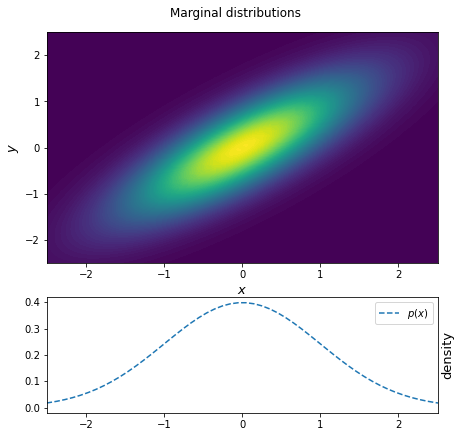

In [6]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(
    2, 1, height_ratios=[2, 1])
plt.suptitle('Marginal distributions', y=0.93)

ax1 = plt.subplot(gs[0])
x, y, p = calculate_pdf(mean_corr, covariance_corr, d)
con = ax1.contourf(x, y, p, 100)
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])

ax2 = plt.subplot(gs[1])
x = np.linspace(-5, 5, 100)
px = univariate_normal(x, mean_corr[0,0], covariance_corr[0, 0])
ax2.plot(x, px, '--', label=f'$p(x)$')
ax2.legend(loc=0)
ax2.set_ylabel('density', fontsize=13)
ax2.yaxis.set_label_position('right')
ax2.set_xlim(-2.5, 2.5);

The same happen when conditioning, which is the probability of one variable depending on another.

$$\begin{aligned}
X|Y \sim \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma^{-1}_{yy}(y-\mu_y), \Sigma_{xx} - \Sigma_{xy} \Sigma^{-1}_{yy}\Sigma_{yx})
\end{aligned}$$

Let's calculate $p(X|y=1)$ for our example:

In [7]:
y_cond = 1.
mean_x_cond_y = mean_corr[0,0] + (covariance_corr[0, 1]*(1/covariance_corr[1, 1])*(1 - mean_corr[1, 0]))
cov_x_cond_y = covariance_corr[0,0] - covariance_corr[0,1]*(1/covariance_corr[1,0]) * covariance_corr[0,1]

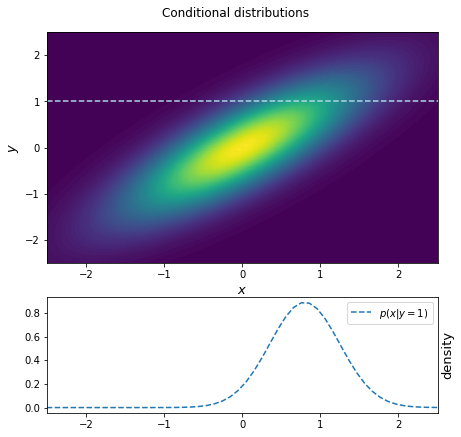

In [8]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(
    2, 1, height_ratios=[2, 1])
plt.suptitle('Conditional distributions', y=0.93)

ax1 = plt.subplot(gs[0])
x, y, p = calculate_pdf(mean_corr, covariance_corr, d)
con = ax1.contourf(x, y, p, 100)
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.plot([-2.5, 2.5], [y_cond, y_cond], color='lightblue', linestyle='dashed')

ax2 = plt.subplot(gs[1])
x = np.linspace(-5, 5, num=100)
px = univariate_normal(x, mean_x_cond_y, cov_x_cond_y)
ax2.plot(x, px, '--', label=f'$p(x|y=1)$')
ax2.legend(loc=0)
ax2.set_ylabel('density', fontsize=13)
ax2.yaxis.set_label_position('right')
ax2.set_xlim(-2.5, 2.5);

## 2.2 Gaussian Process Regression

# 3. Model

## 3.1 Data

In [10]:
covid19 = pd.read_csv('../data/owid-covid-data20210115.csv')

covid = covid19[['location', 'continent', 'date', 'new_cases']] 
covid.columns = ['Country', 'Continent', 'Date', 'Count']
covid['Date'] = covid['Date'].astype('datetime64[ns]')
covid_pt = covid.loc[covid['Country']=='Portugal'].set_index('Date')
c_pt = covid_pt['Count'].fillna(0).reset_index().set_index('Date')['Count'].values
c_pt = np.abs(c_pt)
X = np.arange(c_pt.shape[0]).reshape(-1,1)

Below we can see the evolution of the new cases in Portugal. The spread of a pandemic has a known dynamic, usually well fitted by compartmental models. Nevertheless, countries are taking different measures to stop the spread, some of which with high impact and others with less impact. Portugal just entered a new lockdown.

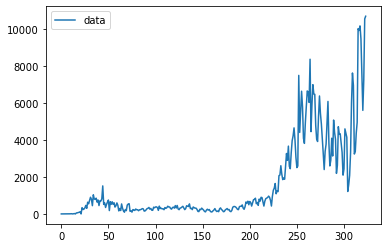

In [11]:
n = c_pt.shape[0]

plt.plot(np.arange(n), c_pt, label='data')
plt.legend();

## 3.2 Model implementation

### 3.2.1 Kernels

Our model is a sum of three GPs for the signal and one GP for the noise:

1. A medium term irregularities represented by an exponentiated quadratic kernel
2. A periodic term.
3. The noise is modeled as a white noise kernel

The prior on $y$ as a function of time is,

\begin{equation}f(t) \sim GP_{med}(0, k_1(x, x')) + GP_{per}(0, k_2(x, x')) + GP_{noise}(0, k_3(x,x'))
\end{equation}

### 3.2.2 Mean Function

If we didn’t specify a mean function in our model, we are assuming that our GP has a mean of zero. This means that as we forecast into the future, the function will eventually return to zero. Is this reasonable in this case? Probably this is not the case for this pandemic and we will have to live with it for the future. The measures that are being taken have the main goal to control the rate of spread not exactly to make it disappear. 

Let's consider a linear function for the mean of our GP, but we will disconsider the intercept as we know that it starts at zero.

### 3.3.3 Likelihood

In our case we are dealing with count data. Nevertheless, we want to use one or more GPs as latent processes for the Poisson mean (and standard deviation, as they are the same).

$$\begin{align}
\theta &\sim g(\phi) \\
f &\sim \textrm{MvNormal}(0, K_{theta}(x)) \\
y_i &\sim \textrm{Poisson}(\exp(f_i)) \forall i \in {1,...,n} 
\end{align}$$

When we use a distribution as the Poisson, we need to ensure that the parameter that we are estimating for the distribution is constraint to the positive real numbers. It can be guaranteed by using the conventional log-link function - this way $\exp(f_i)$ is always positive.

### 3.3.4 Using reparameterization to speed up

Before diving into the model, it is important to note that we are using a non-centered parameterization of our multivarite normal. To explain what this means, we need to recall that the finite dimensional sample from a GP is ultimately a multivariate normal with a parameterized covariance matrix. This means that to add a multivariate normal density over $f$ to the log-posterior density, we need to invert the matrix of decompose it in some way. We use Cholesky decomposition and the factor $L$ is then multiplied by a vector of univariate normals $eta$, so $f$ is implicitly distributed as a multivariate normal random variable.

\begin{align}
\eta_i &\sim \mathcal{N}(0,1) \forall i \in {1,..,n} \\
f &= L\eta \\
f &\sim \text{MvNormal}(0, \Sigma)
\end{align}

This way we remove the prior dependency of the density of $f$ on its hyperparameters (kernel parameters).

### 3.3.5 All together now

In [ ]:
with pm.Model() as model:

    l_t = pm.InverseGamma('l_t', 4, c_pt.shape[0]/2)
    l_p = pm.InverseGamma('l_p', 4, c_pt.shape[0])
    l_ts = pm.Gamma('l_ts', 5, 1)

    η_trend = pm.Gamma('η_trend', 2,1)
    η_ts = pm.HalfNormal('η_ts', 0.15)
    η_per = pm.Gamma('η_per', 5, 1)
    σ  = pm.HalfNormal("σ",  sigma=0.01)
    
    #b = pm.Laplace('b', mu=0, b=0.001)

    #mu_func = pm.gp.mean.Linear(coeffs = b)

    # cov function for the GP 
    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
           + η_per**2 * pm.gp.cov.Periodic(1, period=7, ls=l_p)
           + η_ts**2 * pm.gp.cov.ExpQuad(1, ls=l_ts)
            + pm.gp.cov.WhiteNoise(σ))

    gp = pm.gp.Latent(mean_func=pm.gp.mean.Zero(), cov_func=cov)
    f = gp.prior('f', X=X, reparameterize=True)

    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=c_pt)
    #prior_checks = pm.sample_prior_predictive(200)
    mp = pm.find_MAP(maxeval=5000, progressbar = True)

Now, it it time to condition our model on the new data, i.e. the 30 new time points that we want to forecast.

In [ ]:
X_new = np.arange(c_pt.shape[0]+30).reshape(-1,1)
with pm.Model() as model:
    f_n = gp.conditional('f_n', Xnew=X_new)

    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=tt.exp(f_n), 
                            shape=X_new.shape[0])

    pred_samples = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred_new], 
                                              samples=200,
                                              progressbar = False)

# 4. Results

Finnally, let's plot our results.

In [ ]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, pred_samples['y_pred_new'], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.mean(pred_samples['y_pred_new'], axis=0), label='mean')
plt.plot(np.median(pred_samples['y_pred_new'], axis=0), label='median', color='green')
plt.plot(np.arange(c_pt.shape[0]),c_pt, label='data', color='darkorange')
plt.ylim(0,max(c_pt)*3)
plt.legend();

In [ ]:
n_new = X_new.shape[0]

Zooming in the 30 days that we are forecasting the news are not good. The model estimates an average number of cases that goes up to 15.000. But more importantly it also tells us that the maximum could go to 35.000 cases or, in the case where our measures are very effective, as low as 5.000 - these are the extreme scenarios for the 95% credible interval.

In [ ]:
plt.plot(np.arange(n, n_new), np.mean(pred_samples['y_pred_new'], axis=0)[-30:], label='mean')
plt.fill_between(np.arange(n, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[2.5]).ravel()[-30:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[97.5]).ravel()[-30:], alpha = 0.25, label='95% CI');
plt.legend();

# 5. Conclusion

This article intention is to show the strenght and flexibility of Gaussian processes when dealing with patterns that are specially challenging to fit. With such power comes great responsability when it comes to overfitting. Another important aspect to consider has to do with scalability (O($n^3$). GPs are not known to be very scalable, despite the fact that there are interesting approaches to increase scalability (see ........). 

PS: This article is an exercise, please do not take any action based on its results.